In [ ]:
import jax
import jax.numpy as jnp
import numpy as np

from flax import nnx
import optax

from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mplcursors
from tqdm.notebook import tqdm

from model import DAGMM
from dataloader import get_dataloader, cleanup_dataloader
from utils import calc_mixture_stats, calc_sample_energies
from train import train

In [ ]:
key = jax.random.PRNGKey(42)
batch_size = 1024
key, dataloader_key = jax.random.split(key, 2)

model = DAGMM(n_features=118, rngs=nnx.Rngs(key))
dataloader_train = get_dataloader(dataloader_key, batch_size=batch_size, mode='train')

learning_rate = 0.0001
optimizer = nnx.Optimizer(model, optax.adam(learning_rate))
metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss')
)

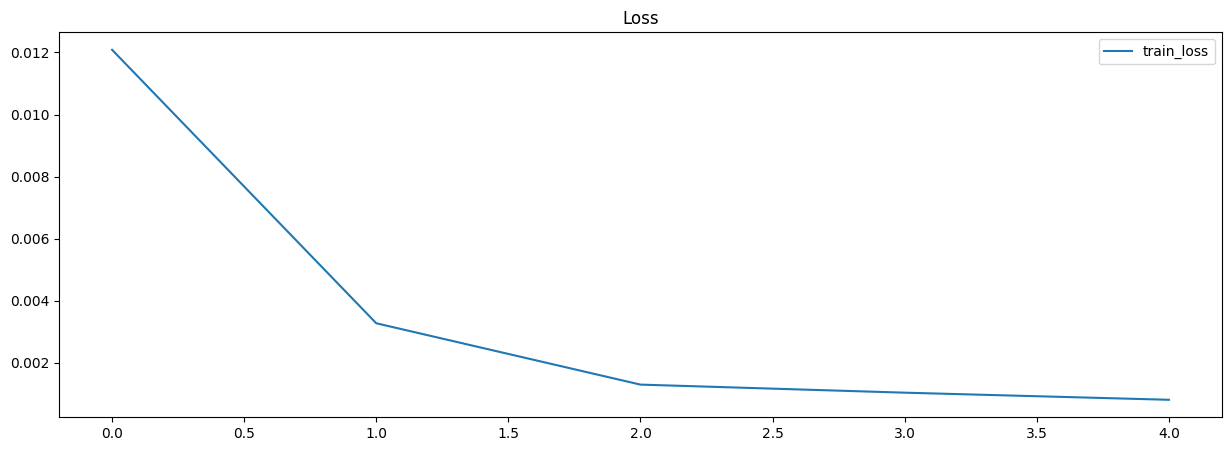

Model saved.


In [60]:
train(model, optimizer, metrics, dataloader_train, epochs=5, save_model=True)


In [61]:
@nnx.jit
def eval_step(model: DAGMM, inputs: jnp.ndarray):
    """Evaluate for a single step."""
    gamma, _, z = model(inputs)
    phi, mu, covariances = calc_mixture_stats(inputs, gamma, z)
    energies = calc_sample_energies(model.k, z, phi, mu, covariances)
    return z, energies

In [62]:
model.eval()

combined_z = jax.device_put([])
combined_energy = jax.device_put([])
combined_labels = []

with tqdm(total=len(dataloader_train)) as pbar:
    pbar.set_description("1. Evaluating training data")
    pbar.update(0)
    for step, (inputs, labels) in enumerate(dataloader_train):
        inputs = jax.tree.map(lambda x: jnp.array(x), inputs)
        z, energies = eval_step(model, inputs)
        
        combined_z.append(z)
        combined_energy.append(energies)
        combined_labels.append(labels)
        pbar.update(1)
        if step == 10:
            break

  0%|          | 0/1917 [00:00<?, ?it/s]

In [63]:
cleanup_dataloader(dataloader_train)
dataloader_test = get_dataloader(dataloader_key, batch_size=batch_size, mode='test')

In [64]:
with tqdm(total=len(dataloader_test)) as pbar:
    pbar.set_description("2. Evaluating test data")
    pbar.update(0)
    for step, (inputs, labels) in enumerate(dataloader_test):
        inputs = jax.tree.map(lambda x: jnp.array(x), inputs)
        z, energies = eval_step(model, inputs)
        
        combined_z.append(z)
        combined_energy.append(energies)
        combined_labels.append(labels)
        pbar.update(1)

z_device = jnp.concatenate(combined_z, axis=0)
energy_device= jnp.concatenate(combined_energy, axis=0)

z = jax.device_get(z_device)
energy = jax.device_get(energy_device)
labels = np.concatenate(combined_labels, axis=0)

  0%|          | 0/2867 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [37]:
threshold = jnp.percentile(energy, 100 - 20)
print(f'Threshold: {threshold}')
y_hat = (energy > threshold).astype(jnp.int32)
y_true = labels.astype(jnp.int32)
print(f'Accuracy: {accuracy_score(y_true, y_hat)}')
precision, recall, f1, _ = prf(y_true, y_hat, average='binary')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

Threshold: 0.5546859502792358
Accuracy: 0.4473544034090909
Precision: 0.3683976919662672
Recall: 0.1473721590909091
F1: 0.21052631578947367


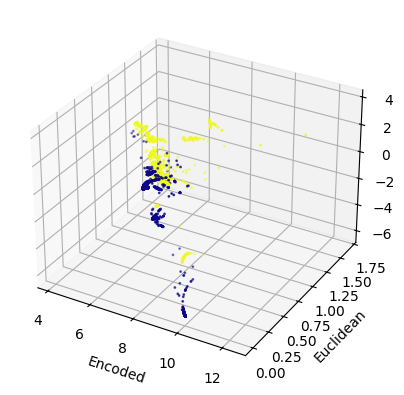

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(z[:, 1], z[:, 0], z[:, 2], c=labels, cmap='plasma', s=1)
ax.set_xlabel('Encoded')
ax.set_ylabel('Euclidean')
ax.set_zlabel('Cosine')

# Add interactivity with mplcursors
mplcursors.cursor(sc, hover=True)

# Show plot
plt.show()